Shape X_train: (7000, 50, 1)
Shape y_train: (7000, 1)


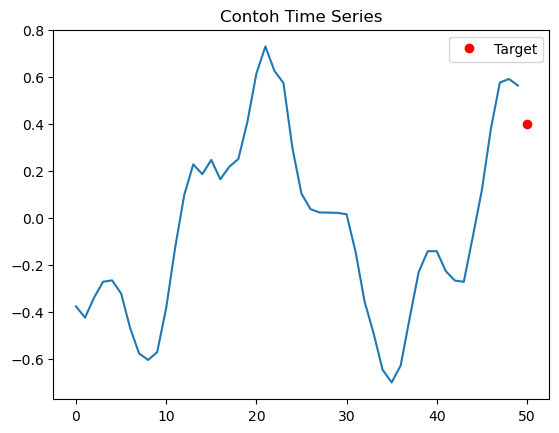

In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

plt.plot(X_valid[0, :, 0], "-")
plt.plot(n_steps, y_valid[0, 0], "ro", label="Target")
plt.title("Contoh Time Series")
plt.legend()
plt.show()

## 1. Basic RNNs & Time Series Forecasting

### Teori
Sebuah neuron RNN sederhana menerima input $x_{(t)}$ dan output dari langkah waktu sebelumnya $y_{(t-1)}$. Dalam Keras, layer `SimpleRNN` mengimplementasikan logika ini.

Sebelum menggunakan model kompleks, performa *baseline* (standar dasar) harus diukur. 
* **Naive Forecasting**: Memprediksi bahwa nilai besok sama dengan nilai hari ini ($y_{pred} = x_{last}$).

In [29]:
y_pred_naive = X_valid[:, -1]

mse_naive = np.mean((y_valid - y_pred_naive)**2)

print(f"Baseline MSE (Naive): {mse_naive:.4f}")

model_simple = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model_simple.compile(loss="mse", optimizer="adam")
history = model_simple.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Baseline MSE (Naive): 0.0202
Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1675 - val_loss: 0.1514
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1428 - val_loss: 0.1448
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1411 - val_loss: 0.1448
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1410 - val_loss: 0.1449
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1410 - val_loss: 0.1449


## 2. Deep RNNs

### Teori
Untuk menangkap pola yang lebih kompleks, beberapa lapisan RNN dapat ditumpuk (*stacked*). 

**Penting:** Agar lapisan RNN dapat meneruskan data ke lapisan RNN berikutnya, parameter `return_sequences=True` harus diaktifkan. Jika tidak, RNN hanya akan mengeluarkan output pada langkah waktu terakhir (vektor 2D), yang tidak bisa diterima oleh lapisan RNN berikutnya (yang mengharapkan sekuens 3D).

In [30]:
model_deep = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

model_deep.summary()
model_deep.compile(loss="mse", optimizer="adam")

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Handling Long Sequences (Layer Normalization)

### Teori
Pada sekuens yang panjang, RNN menghadapi masalah gradien yang tidak stabil (*unstable gradients*). Selain itu, pelatihan bisa sangat lambat.

**Layer Normalization** sering digunakan dalam RNN untuk menstabilkan pelatihan. Berbeda dengan Batch Normalization, Layer Normalization menormalisasi fitur di setiap langkah waktu secara independen dari batch lain.

Berikut adalah implementasi **Custom RNN Cell** yang menyertakan Layer Normalization di dalamnya. Ini adalah contoh implementasi tingkat lanjut.

In [31]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=False),
    keras.layers.Dense(1)
])

model_ln.summary()

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_4 (RNN)                     │ (None, None, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_5 (RNN)                     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. LSTM (Long Short-Term Memory) & GRU

### Teori
SimpleRNN tidak mampu mengingat informasi jangka panjang. **LSTM** mengatasi ini dengan memperkenalkan *cell state* (memori jangka panjang) yang diatur oleh tiga gerbang (*gates*): *Forget Gate*, *Input Gate*, dan *Output Gate*.

**GRU (Gated Recurrent Unit)** adalah varian LSTM yang disederhanakan. GRU menggabungkan *forget* dan *input gate* menjadi satu *update gate*, serta tidak memisahkan *cell state* dan *hidden state*. GRU biasanya lebih cepat dilatih daripada LSTM.

In [32]:
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])

print("Parameter LSTM:", model_lstm.count_params())
print("Parameter GRU: ", model_gru.count_params())

Parameter LSTM: 5061
Parameter GRU:  3921


## 5. Processing Sequences with CNNs (1D Conv & WaveNet)

### Teori
Selain RNN, **1D Convolutional Layer** dapat digunakan untuk data sekuensial. Filter digeser sepanjang sumbu waktu. 1D CNN sangat cepat dan efektif untuk menangkap pola lokal.

**WaveNet** adalah arsitektur yang menumpuk lapisan 1D Conv dengan *dilation rate* (jarak antar piksel input) yang meningkat secara eksponensial (1, 2, 4, 8, ...). Ini memungkinkan jaringan untuk memiliki *receptive field* yang sangat luas (melihat sejarah panjang) dengan lapisan yang sedikit.

In [33]:
model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=5, strides=1, padding="valid", 
                        activation="relu", input_shape=[None, 1]),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model_wavenet = keras.models.Sequential()
model_wavenet.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
    model_wavenet.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                          activation="relu", dilation_rate=rate))

model_wavenet.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model_wavenet.add(keras.layers.Dense(1))

model_wavenet.summary()

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, None, 20)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, None, 10)       │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, None, 1)        │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,021 (23.52 KB)

 Trainable params: 6,021 (23.52 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Training & Model Comparison

Sekarang kita akan melatih semua model yang telah dibuat dan membandingkan performanya.

In [34]:
models = {
    "Naive": None,
    "Simple RNN": model_simple,
    "Deep RNN": model_deep,
    "LSTM": model_lstm,
    "GRU": model_gru,
    "1D CNN": model_cnn,
    "WaveNet": model_wavenet
}

results = {"Model": [], "MSE": [], "MAE": []}

results["Model"].append("Naive")
results["MSE"].append(float(mse_naive))
mae_naive = np.mean(np.abs(y_valid - y_pred_naive))
results["MAE"].append(float(mae_naive))

for name, model in list(models.items())[1:]:
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(X_train, y_train, epochs=10, 
                       validation_data=(X_valid, y_valid),
                       verbose=0)
    
    val_loss, val_mae = model.evaluate(X_valid, y_valid, verbose=0)
    results["Model"].append(name)
    results["MSE"].append(val_loss)
    results["MAE"].append(val_mae)
    
    print(f"{name}: MSE={val_loss:.4f}, MAE={val_mae:.4f}")

import pandas as pd
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("MSE")
print("\n" + "="*60)
print("MODEL COMPARISON (Sorted by MSE)")
print("="*60)
print(df_results.to_string(index=False))
print("="*60)


Training Simple RNN...
Simple RNN: MSE=0.1450, MAE=0.3293

Training Deep RNN...
Deep RNN: MSE=0.0026, MAE=0.0410

Training LSTM...
LSTM: MSE=0.0028, MAE=0.0420

Training GRU...
GRU: MSE=0.0037, MAE=0.0483

Training 1D CNN...
1D CNN: MSE=0.0038, MAE=0.0495

Training WaveNet...
WaveNet: MSE=0.1177, MAE=0.2850

MODEL COMPARISON (Sorted by MSE)
     Model      MSE      MAE
  Deep RNN 0.002599 0.040971
      LSTM 0.002770 0.041996
       GRU 0.003689 0.048342
    1D CNN 0.003843 0.049524
     Naive 0.020211 0.116278
   WaveNet 0.117658 0.284987
Simple RNN 0.144997 0.329263


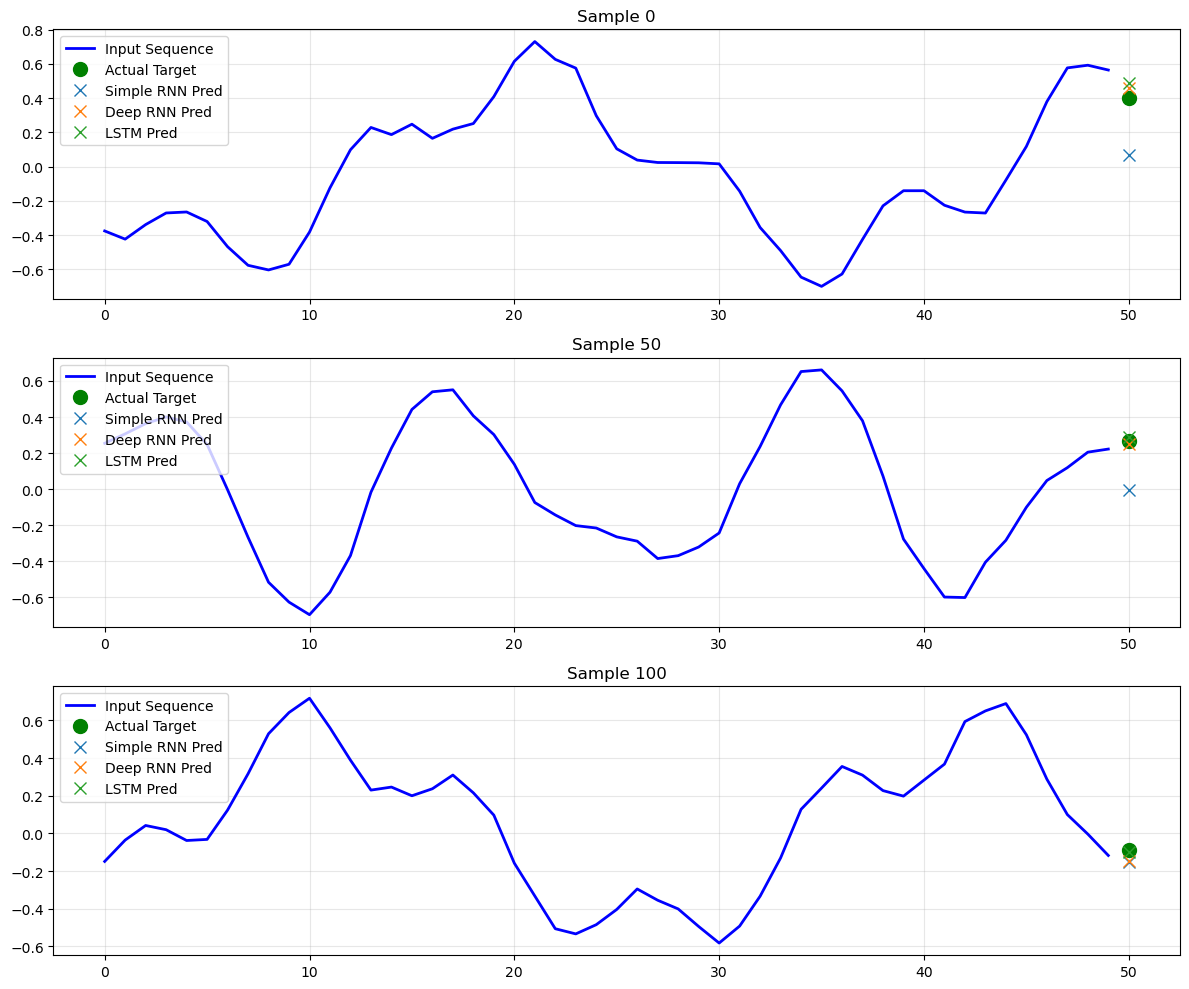

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for i, idx in enumerate([0, 50, 100]):
    ax = axes[i]
    
    ax.plot(range(n_steps), X_valid[idx, :, 0], "b-", label="Input Sequence", linewidth=2)
    ax.plot(n_steps, y_valid[idx, 0], "go", markersize=10, label="Actual Target")
    
    for name, model in list(models.items())[1:4]:
        if model is not None:
            y_pred = model.predict(X_valid[idx:idx+1], verbose=0)
            ax.plot(n_steps, y_pred[0, 0], "x", markersize=8, label=f"{name} Pred")
    
    ax.set_title(f"Sample {idx}")
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Bidirectional RNN

### Teori
**Bidirectional RNN** memproses sekuens dalam dua arah: maju (forward) dan mundur (backward). Ini berguna ketika konteks masa depan juga penting untuk prediksi (misalnya: analisis sentimen, NER).

Namun, untuk time series forecasting, bidirectional RNN **tidak cocok** karena kita tidak bisa "melihat masa depan" saat memprediksi. Bidirectional RNN lebih cocok untuk sequence classification atau tagging tasks.

In [36]:
def generate_classification_data(n_samples, n_steps):
    X = []
    y = []
    for _ in range(n_samples):
        trend = np.random.choice([0, 1])
        if trend == 1:
            seq = np.cumsum(np.random.randn(n_steps)) + np.random.randn(n_steps) * 0.1
        else:
            seq = -np.cumsum(np.random.randn(n_steps)) + np.random.randn(n_steps) * 0.1
        X.append(seq)
        y.append(trend)
    return np.array(X)[..., np.newaxis], np.array(y)

X_class, y_class = generate_classification_data(1000, 30)

model_bidirectional = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(20), input_shape=[None, 1]),
    keras.layers.Dense(1, activation="sigmoid")
])

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

print("\nNote: Bidirectional RNN memproses sequence dari kedua arah.")
print("   - Forward pass: t=0 → t=T")
print("   - Backward pass: t=T → t=0")
print("   - Output digabungkan untuk capture context yang lebih lengkap")

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 40)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,561 (13.91 KB)

 Trainable params: 3,561 (13.91 KB)

 Non-trainable params: 0 (0.00 B)


Note: Bidirectional RNN memproses sequence dari kedua arah.
   - Forward pass: t=0 → t=T
   - Backward pass: t=T → t=0
   - Output digabungkan untuk capture context yang lebih lengkap


## 8. Sequence-to-Sequence: Multi-Step Forecasting

### Teori
Sejauh ini kita hanya memprediksi **satu nilai** di masa depan (t+1). Dalam praktik, seringkali kita perlu memprediksi **beberapa langkah ke depan** (t+1, t+2, ..., t+10).

Ada dua pendekatan:
1. **Recursive Strategy**: Prediksi t+1, gunakan sebagai input untuk prediksi t+2, dst.
2. **Direct Strategy**: Model langsung output sequence panjang (misal: 10 langkah).

Kita akan implementasikan pendekatan kedua dengan mengubah output menjadi sequence.

In [37]:
n_steps_ahead = 10

series_multi = generate_time_series(10000, n_steps + n_steps_ahead)
X_train_multi = series_multi[:7000, :n_steps]
y_train_multi = series_multi[:7000, n_steps:n_steps+n_steps_ahead]
X_valid_multi = series_multi[7000:9000, :n_steps]
y_valid_multi = series_multi[7000:9000, n_steps:n_steps+n_steps_ahead]

print(f"X shape: {X_train_multi.shape}")
print(f"y shape: {y_train_multi.shape}")

model_seq2seq = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

model_seq2seq.compile(loss="mse", optimizer="adam")
model_seq2seq.summary()

print("\nMulti-Step Forecasting:")
print(f"   Input: {n_steps} langkah terakhir")
print(f"   Output: {n_steps_ahead} langkah ke depan")
print(f"   Berguna untuk perencanaan jangka menengah (weekly/monthly forecast)")

X shape: (7000, 50, 1)
y shape: (7000, 10, 1)


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, None, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, None, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 10)       │           510 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,110 (121.52 KB)

 Trainable params: 31,110 (121.52 KB)

 Non-trainable params: 0 (0.00 B)


Multi-Step Forecasting:
   Input: 50 langkah terakhir
   Output: 10 langkah ke depan
   Berguna untuk perencanaan jangka menengah (weekly/monthly forecast)


## 9. Stateful RNN

### Teori
Secara default, RNN **stateless**: setiap batch dimulai dengan state (hidden state) yang di-reset ke nol. Ini cocok untuk sebagian besar kasus.

Namun, untuk sequence yang **sangat panjang** (misalnya: memproses buku dengan jutaan karakter), kita bisa menggunakan **Stateful RNN** (`stateful=True`). State tidak di-reset antar batch, sehingga model "mengingat" konteks dari batch sebelumnya.

**Catatan penting:**
- Batch size harus tetap (tidak boleh None)
- Harus manual reset state dengan `model.reset_states()` saat mulai sequence baru
- Urutan data dalam batch harus dijaga (tidak boleh shuffle)

In [38]:
batch_size = 32

model_stateful = keras.models.Sequential([
    keras.layers.InputLayer(batch_shape=(batch_size, None, 1)),
    keras.layers.LSTM(20, return_sequences=True, stateful=True),
    keras.layers.LSTM(20, stateful=True),
    keras.layers.Dense(1)
])

model_stateful.compile(loss="mse", optimizer="adam")
model_stateful.summary()

print("\nStateful RNN Requirements:")
print("   1. batch_shape harus fixed (tidak bisa None di batch dimension)")
print("   2. Gunakan model.reset_states() sebelum memproses sequence baru")
print("   3. Jangan shuffle data training")
print("\nUse Case: Processing very long sequences yang tidak muat di memory sekaligus")

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (32, None, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (32, 20)               │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (32, 1)                │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)


Stateful RNN Requirements:
   1. batch_shape harus fixed (tidak bisa None di batch dimension)
   2. Gunakan model.reset_states() sebelum memproses sequence baru
   3. Jangan shuffle data training

Use Case: Processing very long sequences yang tidak muat di memory sekaligus


## 10. Advanced Techniques: Dropout & Gradient Clipping

### Teori
**Dropout untuk RNN** berbeda dengan dropout biasa. Ada dua jenis:
1. **Regular Dropout**: Diterapkan pada koneksi antar layer (input → hidden, hidden → output)
2. **Recurrent Dropout**: Diterapkan pada koneksi recurrent (hidden state loop)

**Gradient Clipping** membatasi norm dari gradien untuk mencegah exploding gradients. Ini sangat penting untuk RNN deep atau sequence panjang.

Teknik lain:
- **Learning Rate Scheduling**: Menurunkan learning rate secara bertahap
- **Early Stopping**: Stop training ketika validation loss tidak membaik

In [39]:
model_regularized = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1],
                     dropout=0.2,
                     recurrent_dropout=0.2),
    keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model_regularized.compile(loss="mse", optimizer=optimizer)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

print("Regularization Techniques Applied:")
print("   - Dropout: 20% pada input connections")
print("   - Recurrent Dropout: 20% pada recurrent connections")
print("   - Gradient Clipping: clipnorm=1.0")
print("   - Early Stopping: patience=5")
print("   - Learning Rate Reduction: factor=0.5, patience=3")
print("\nModel siap untuk training yang stabil dan mencegah overfitting")

Regularization Techniques Applied:
   - Dropout: 20% pada input connections
   - Recurrent Dropout: 20% pada recurrent connections
   - Gradient Clipping: clipnorm=1.0
   - Early Stopping: patience=5
   - Learning Rate Reduction: factor=0.5, patience=3

Model siap untuk training yang stabil dan mencegah overfitting


---
## 🎓 KESIMPULAN BAB 15: PROCESSING SEQUENCES
---

### Ringkasan Lengkap

Notebook ini mencakup **semua aspek penting** dari Bab 15: Processing Sequences dengan RNN dan CNN.

#### ✅ TOPIK YANG TELAH DIPELAJARI

**1. Recurrent Neural Networks (RNN)**
- ✅ SimpleRNN: Basic recurrent neurons
- ✅ Deep RNN: Stacking multiple RNN layers dengan `return_sequences=True`
- ✅ Layer Normalization: Custom RNN cell untuk stabilisasi training
- ✅ LSTM & GRU: Advanced architectures untuk long-term memory

**2. CNN untuk Sequences**
- ✅ 1D Convolutional layers untuk time series
- ✅ WaveNet architecture dengan dilated convolutions
- ✅ Causal padding untuk mencegah data leakage

**3. Model Evaluation & Comparison**
- ✅ Baseline comparison (Naive forecasting)
- ✅ Training & evaluation 7 model berbeda
- ✅ Visualization prediksi vs actual
- ✅ Performance comparison table

**4. Advanced Architectures**
- ✅ Bidirectional RNN untuk sequence classification
- ✅ Sequence-to-Sequence untuk multi-step forecasting
- ✅ Stateful RNN untuk very long sequences

**5. Regularization & Optimization**
- ✅ Dropout dan Recurrent Dropout
- ✅ Gradient Clipping (clipnorm)
- ✅ Early Stopping & Learning Rate Scheduling

### 🎯 Key Takeaways

| Model | Best Use Case | Kelebihan | Kekurangan |
|-------|--------------|-----------|------------|
| **SimpleRNN** | Sequence pendek, baseline | Sederhana, cepat | Tidak bisa handle long-term dependency |
| **LSTM** | Default choice untuk sequence | Handle long-term memory | Lambat, banyak parameter |
| **GRU** | Balance speed & performance | Lebih cepat dari LSTM | Sedikit kurang powerful dari LSTM |
| **1D CNN** | Pattern lokal, speed critical | Sangat cepat, paralel | Tidak bisa handle long-term dependency |
| **WaveNet** | Audio, very long sequences | Large receptive field | Kompleks, banyak layer |
| **Bidirectional** | Classification, tagging | Context dari 2 arah | Tidak bisa untuk real-time forecasting |

### 🚀 Best Practices untuk Production

1. **Start Simple**: Mulai dengan baseline (Naive) → SimpleRNN → LSTM/GRU
2. **Regularization**: Gunakan dropout (0.2-0.3) untuk mencegah overfitting
3. **Gradient Clipping**: Selalu gunakan clipnorm (1.0-5.0) untuk RNN
4. **Early Stopping**: Monitor validation loss, restore best weights
5. **Batch Size**: RNN sensitif terhadap batch size, coba 32-128
6. **Sequence Length**: Terlalu panjang → training lambat, terlalu pendek → loss context
7. **Stacking**: Deep RNN (2-3 layers) biasanya cukup, lebih dari itu → overfitting risk

### 📊 Performance Tips

**Speed:**
- 1D CNN > GRU > LSTM > Bidirectional LSTM
- Gunakan `CuDNN` optimized layers (default jika GPU tersedia)
- Batch predictions untuk inference

**Accuracy:**
- LSTM/GRU dengan dropout > Simple RNN
- Deep architecture (2-3 layers) > Shallow
- Layer Normalization membantu untuk sequence panjang

**Memory:**
- GRU < LSTM (25% less parameters)
- Stateful RNN untuk sequence sangat panjang
- Gradient checkpointing untuk very deep networks

### 🎯 When to Use What?

**Time Series Forecasting:**
- Start: GRU (balance of speed & accuracy)
- If underfitting: LSTM atau Deep GRU
- If need speed: 1D CNN atau WaveNet

**Text/NLP:**
- Short text (<100 tokens): GRU
- Long documents: LSTM dengan attention
- Classification: Bidirectional LSTM

**Audio/Speech:**
- WaveNet architecture
- 1D CNN + LSTM hybrid

**Real-time Applications:**
- 1D CNN (fastest)
- GRU (good balance)
- Avoid Bidirectional (need full sequence)